In [108]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys, AllChem, rdmolops, DataStructs
from rdkit.Chem import Draw
import numpy as np
import requests
import pandas as pd
from base64 import b64decode
import time
from itertools import combinations, product
import random
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
mol = Chem.MolFromSmiles('CC(C)C1=C(C(=C(N1CC[C@H](C[C@H](CC(=O)O)O)O)C2=CC=C(C=C2)F)C3=CC=CC=C3)C(=O)NC4=CC=CC=C4')

In [3]:
# maccs key

fp = MACCSkeys.GenMACCSKeys(mol)
print(type(fp))

for i in range(len(fp)):
    print(fp[i], end='')

<class 'rdkit.DataStructs.cDataStructs.ExplicitBitVect'>
00000000000000000000000000000000000000000010000000000100000000100100000000110000100101010111100011001000100110110000011001110100110111111101101011111111111111111111110

In [4]:
fp.ToBitString()

'00000000000000000000000000000000000000000010000000000100000000100100000000110000100101010111100011001000100110110000011001110100110111111101101011111111111111111111110'

In [5]:
print(len(fp))
print(fp.GetNumBits())
print(fp.GetNumOffBits())
print(fp.GetNumOnBits())
print(fp.ToBinary())

167
167
105
62
b'\xe0\xff\xff\xff\xa7\x00\x00\x00>\x00\x00\x00T\x14\x10\x04\x10\x00\x08\x04\x02\x02\x02\x00\x00\x00\x06\x00\x04\x06\x04\x00\x02\x00\n\x00\x04\x00\x00\x02\x04\x00\x02\x00\x00\x00\x00\x00\x00\x02\x00\x02\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02'


In [6]:
# generate maccs keys
# get positions of on bits
# predefined fragment dict
# check bit definitions at https://github.com/rdkit/rdkit/blob/master/rdkit/Chem/MACCSkeys.py

def ex_1a(smiles):
    
    # smiles to mol
    mols = [Chem.MolFromSmiles(smile) for smile in smiles]
    
    # smile to name
    names = []
    for smile in smiles:
        url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{smile}/property/iupacname/txt'
        r = requests.get(url)
        name = r.text.strip()
        names.append(name)
    
    # smile to maccs key
    data = []
    for i, mol in enumerate(mols):
        fp = MACCSkeys.GenMACCSKeys(mol)
        on_bits = np.array(fp.GetOnBits())
        data.append([smiles[i], on_bits])
        
    df = pd.DataFrame(data, columns=['smile', 'on_bits'])
    df['name'] = names
    
    return df[['name', 'smile', 'on_bits']]

In [7]:
smiles = [ 'C1=CC=CC=C1', # Benzene (Kekule)
           'c1ccccc1',    # Benzene ("Aromatized" carbons)
           'C1CCCCC1']     # Cyclohexene

In [8]:
ex_1a(smiles)

,name,smile,on_bits
0,benzene,C1=CC=CC=C1,"[162, 163, 165]"
1,benzene,c1ccccc1,"[162, 163, 165]"
2,cyclohexane,C1CCCCC1,"[118, 128, 129, 147, 163, 165]"


In [9]:
# name to smile
# 512 morgan fp from smile
# print fp

def ex_2a(names):
    
    # name to smile
    smiles = []
    for name in names:
        url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{name}/property/isomericsmiles/txt'    
        r = requests.get(url)
        smile = r.text.strip()
        smiles.append(smile)
        
    # smile to fp
    mols = [Chem.MolFromSmiles(smile) for smile in smiles]
    for i, mol in enumerate(mols):
        info= {}
        #fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 512, bitInfo=info)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 512, bitInfo=info).ToBitString()
        print(names[i])
        #print(info)
        print(fp)

In [10]:
synonyms = [ 'diphenhydramine', 'cetirizine', 'fexofenadine', 'loratadine' ]
ex_2a(synonyms)

diphenhydramine
01000000000001000000000000000000010000000000010000000000000000001000000000100000100000000000000000000000000000000000000000000000000000000001100000000000000000000000000000000001000001010000000100000000000000000000001000000000000000000000000000000000000000000000000000000000001000000000000000000000000000100001000000001000000000000000000001000100000000000000100000000000010000000000000000000100000010000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
cetirizine
0100000000000101000001000000000000000000000001100100000000010000100000000010000010000000000100000000000000000000000000000100000000000000001001000001000000000000000000000000100100000001000000000000000001000000000000101000000000000000000000000100000000010001000000000000000000000000000000000000000101000000100000000000010000000000000000000100110000000000000010000000000000000000000001000000010000000000000000000000001000000001000000000000000000000000000000001010

In [11]:
# bitstring to fp
# from diphenhydramine
bit_str = '01000000000001000000000000000000010000000000010000000000000000001000000000100000100000000000000000000000000000000000000000000000000000000001100000000000000000000000000000000001000001010000000100000000000000000000001000000000000000000000000000000000000000000000000000000000001000000000000000000000000000100001000000001000000000000000000001000100000000000000100000000000010000000000000000000100000010000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'

fp = DataStructs.cDataStructs.CreateFromBitString(bit_str)
np.array(fp.GetOnBits())

array([  1,  13,  33,  45,  64,  74,  80, 139, 140, 175, 181, 183, 191,
       214, 274, 302, 307, 316, 337, 341, 356, 369, 389, 396, 415])

In [12]:
# path based fp

fp = rdmolops.RDKFingerprint(mol, fpSize=2048, minPath=1, maxPath=7).ToBitString()
print(fp)

1101110111110101011111001011111010111101111010011111111111011100111111110110111101111111111110111111101111110111110101001011011101111101111111111101101101111110111000110111111100011001010111111111011011101101011111010111110111100111111101111110111111001110111011101001011000111000111101100111111000111111100111101111111000010000111110111111011111111100011111111111111011100101011101111111110111101111101000011011010111111111011111101110011101111011011101011111101111111110111111011101101110111111111101111111111111101111010010001111111111011010111011000110111110111011110101111010111111110101001001111001011110111011001100001111011101111111111011111111011110111100100001110100111111111001110110101111100101110100111101101101111101111111111111111101110111000011101111101111011111010100111100111011111111111111110110111111011010111111100111100110110110011111110011110110101011111100010111110110111111111011011111111101111101101111111101111110101110101001001110110110111011111001111100001110101111001111

In [13]:
def PCFP_BitString(pcfp_base64):
    
    pcfp_bitstring = ''.join(['{:08b}'.format(x) for x in b64decode(pcfp_base64)])[32:913]

    return pcfp_bitstring

In [14]:
pcfps = 'AAADcYBgAAAAAAAAAAAAAAAAAAAAAAAAAAAwAAAAAAAAAAABAAAAGAAAAAAACACAEAAwAIAAAACAACBCAAACAAAgAAAIiAAAAIgIICKAERCAIAAggAAIiAcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA=='
print(len(PCFP_BitString(pcfps)))
print(PCFP_BitString(pcfps))

881
10000000011000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001100000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000001100000000000000000000000000000000000000000000000100000000000100000000001000000000000001100000000000010000000000000000000000000000000100000000000000000100000010000100000000000000000000000100000000000000000001000000000000000000000000010001000100000000000000000000000000010001000000010000010000000100010100000000001000100010000100000000010000000000000001000001000000000000000000010001000100000000111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


In [15]:
bitvect = DataStructs.CreateFromBitString(PCFP_BitString(pcfps))
type(bitvect)

rdkit.DataStructs.cDataStructs.ExplicitBitVect

In [16]:
cids = [    54454,  # Simvastatin (Zocor)
            54687,  # Pravastatin (Pravachol)
            60823,  # Atorvastatin (Lipitor)
           446155,  # Fluvastatin (Lescol)   
           446157,  # Rosuvastatin (Crestor)
          5282452,  # Pitavastatin (Livalo)
         97938126 ] # Lovastatin (Altoprev)

In [17]:
prolog = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug'

str_cid = ','.join([str(x) for x in cids])
url = prolog + '/compound/cid/' + str_cid + '/property/isomericsmiles/txt'
res = requests.get(url)
smiles = res.text.split()
smiles

['CCC(C)(C)C(=O)O[C@H]1C[C@H](C=C2[C@H]1[C@H]([C@H](C=C2)C)CC[C@@H]3C[C@H](CC(=O)O3)O)C',
 'CC[C@H](C)C(=O)O[C@H]1C[C@@H](C=C2[C@H]1[C@H]([C@H](C=C2)C)CC[C@H](C[C@H](CC(=O)O)O)O)O',
 'CC(C)C1=C(C(=C(N1CC[C@H](C[C@H](CC(=O)O)O)O)C2=CC=C(C=C2)F)C3=CC=CC=C3)C(=O)NC4=CC=CC=C4',
 'CC(C)N1C2=CC=CC=C2C(=C1/C=C/[C@H](C[C@H](CC(=O)O)O)O)C3=CC=C(C=C3)F',
 'CC(C)C1=NC(=NC(=C1/C=C/[C@H](C[C@H](CC(=O)O)O)O)C2=CC=C(C=C2)F)N(C)S(=O)(=O)C',
 'C1CC1C2=NC3=CC=CC=C3C(=C2/C=C/[C@H](C[C@H](CC(=O)O)O)O)C4=CC=C(C=C4)F',
 'CC[C@H](C)C(=O)O[C@@H]1C[C@@H](C[C@@H]2[C@H]1[C@H]([C@H](C=C2)C)CC[C@@H]3C[C@H](CC(=O)O3)O)C']

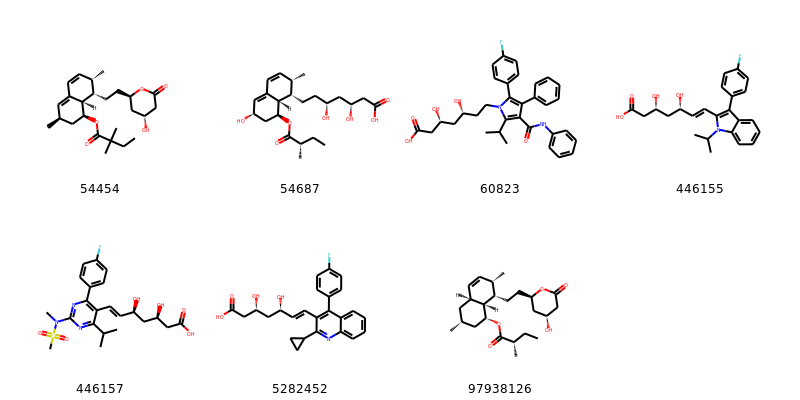

In [18]:
mols = [Chem.MolFromSmiles(smile) for smile in smiles]
Chem.Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200, 200), legends=[str(x) for x in cids])

In [19]:
# generate maccs keys
fps = [MACCSkeys.GenMACCSKeys(x) for x in mols]

In [20]:
# pair-wise similarity scores
for i in range(0, len(fps)):
    for j in range(i+1, len(fps)):
        score = DataStructs.FingerprintSimilarity(fps[i], fps[j])
        print(cids[i], 'vs', cids[j], ':', round(score, 3), end='')
        
        if score >= 0.85:
            print(' ****')
        elif score >= 0.75:
            print(' ***')
        elif score >= 0.55:
            print(' *')
        else:
            print(' ')
    

54454 vs 54687 : 0.812 ***
54454 vs 60823 : 0.354 
54454 vs 446155 : 0.379 
54454 vs 446157 : 0.307 
54454 vs 5282452 : 0.4 
54454 vs 97938126 : 0.867 ****
54687 vs 60823 : 0.387 
54687 vs 446155 : 0.397 
54687 vs 446157 : 0.287 
54687 vs 5282452 : 0.421 
54687 vs 97938126 : 0.8 ***
60823 vs 446155 : 0.662 *
60823 vs 446157 : 0.535 
60823 vs 5282452 : 0.507 
60823 vs 97938126 : 0.365 
446155 vs 446157 : 0.526 
446155 vs 5282452 : 0.735 *
446155 vs 97938126 : 0.393 
446157 vs 5282452 : 0.473 
446157 vs 97938126 : 0.298 
5282452 vs 97938126 : 0.444 


In [21]:
print('tanimoto', round(DataStructs.TanimotoSimilarity(fps[0], fps[1]), 4))
print('dice', round(DataStructs.DiceSimilarity(fps[0], fps[1]), 4))
print('cosine', round(DataStructs.CosineSimilarity(fps[0], fps[1]), 4))
print('sokal', round(DataStructs.SokalSimilarity(fps[0], fps[1]), 4))
print('mcconnaughey', round(DataStructs.McConnaugheySimilarity(fps[0], fps[1]), 4))

tanimoto 0.8125
dice 0.8966
cosine 0.8971
sokal 0.6842
mcconnaughey 0.7952


In [22]:
for i in range(0, 11):
    
    alpha = round(i * 0.1, 1)
    beta = round(1 - alpha, 1)
    print('(alpha, beta) = ({}, {}) : '.format(alpha, beta), end='')
    print(round(DataStructs.TverskySimilarity(fps[0], fps[1], alpha, beta), 4))

(alpha, beta) = (0.0, 1.0) : 0.9286
(alpha, beta) = (0.1, 0.9) : 0.922
(alpha, beta) = (0.2, 0.8) : 0.9155
(alpha, beta) = (0.3, 0.7) : 0.9091
(alpha, beta) = (0.4, 0.6) : 0.9028
(alpha, beta) = (0.5, 0.5) : 0.8966
(alpha, beta) = (0.6, 0.4) : 0.8904
(alpha, beta) = (0.7, 0.3) : 0.8844
(alpha, beta) = (0.8, 0.2) : 0.8784
(alpha, beta) = (0.9, 0.1) : 0.8725
(alpha, beta) = (1.0, 0.0) : 0.8667


In [23]:
# cids to smiles
# smiles to fingerprints
# fingerprint to bitvector
# tanimoto scores

def ex_2a(cids):
    
    # smiles
    cids_str = ','.join(map(str, cids))
    url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cids_str}/property/isomericsmiles/txt'
    r = requests.get(url)
    smiles = r.text.split()
    
    # to fingerprint
    mols = [Chem.MolFromSmiles(smile) for smile in smiles]
    fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1025) for mol in mols]
    
    # tanimoto scores
    data = []
    for i in range(0, len(cids)):
        for j in range(1, len(cids)):
            score = DataStructs.TanimotoSimilarity(fps[i], fps[j])
            data.append([cids[i], cids[j], score])
    
    #combos = combinations(fps, 2)
    #for combo in combos:
    #    score = DataStructs.TanimotoSimilarity(combo[0], combo[1])
    #    data.append()
            
    df = pd.DataFrame(data, columns=['cid_1', 'cid_2', 'score'])
    
    return df

In [24]:
ex_2a(cids)

,cid_1,cid_2,score
0,54454,54687,0.373494
1,54454,60823,0.085714
2,54454,446155,0.090000
3,54454,446157,0.104762
4,54454,5282452,0.088235
5,54454,97938126,0.447368
6,54687,54687,1.000000
7,54687,60823,0.252747
8,54687,446155,0.224719
9,54687,446157,0.208333


In [25]:
random.seed(0)

# max cid in pubchem
cid_max = 138962044

In [26]:
# select 1000 random 
cids = []
for x in range(1000):
    cids.append(random.randint(1, cid_max + 1))
    
chunk_size = 100
num_chunks = len(cids) // chunk_size

smiles = []
for i in range(num_chunks):
    if i == 0:
        print(f'processing chunk {i}')
    idx1 = chunk_size * i
    idx2 = chunk_size * (i+1)
    str_cids = ','.join([str(x) for x in cids[idx1:idx2]])
    
    url = prolog + '/compound/cid/' + str_cids + '/property/isomericsmiles/txt'
    res = requests.get(url)
    
    if res.status_code == 200:
        smiles.extend(res.text.split())
        
    else:
        print(f'chunk {i} failed to get smiles')
    
    time.sleep(0.2)
    
print('done')
print('# of smiles: {}'.format(len(smiles)))
    

processing chunk 0
done
# of smiles: 1000


In [27]:
mols = [Chem.MolFromSmiles(smile) for smile in smiles if x != None]
fps = [MACCSkeys.GenMACCSKeys(x) for x in mols if x != None]
print('# number of compounds: {}'.format(len(mols)))
print('# number of fingerprints: {}'.format(len(fps)))

RDKit WARNING: [01:07:02] WARNING: not removing hydrogen atom without neighbors


# number of compounds: 1000
# number of fingerprints: 1000


In [28]:
# get nones

#print('smiles at index {}'.format(mols.index(None)))
#print('{}'.format(smiles[mols.index(None)]))

In [102]:
print('# the number of compound pairs is {}'.format((len(fps) * (len(fps)-1))/2))

# the number of compound pairs is 499500.0


In [104]:
scores = []
for i in range(0, len(fps)):
    if i == 0:
        print('processing compound ', end='')
        
    if i % 100 == 0:
        print(i, end=' ')
    
    for j in range(i+1, len(fps)):
        scores.append(DataStructs.FingerprintSimilarity(fps[i], fps[j]))
        
print('done')
print('# number of scores', len(scores))

processing compound 0 100 200 300 400 500 600 700 800 900 done
# number of scores 499500


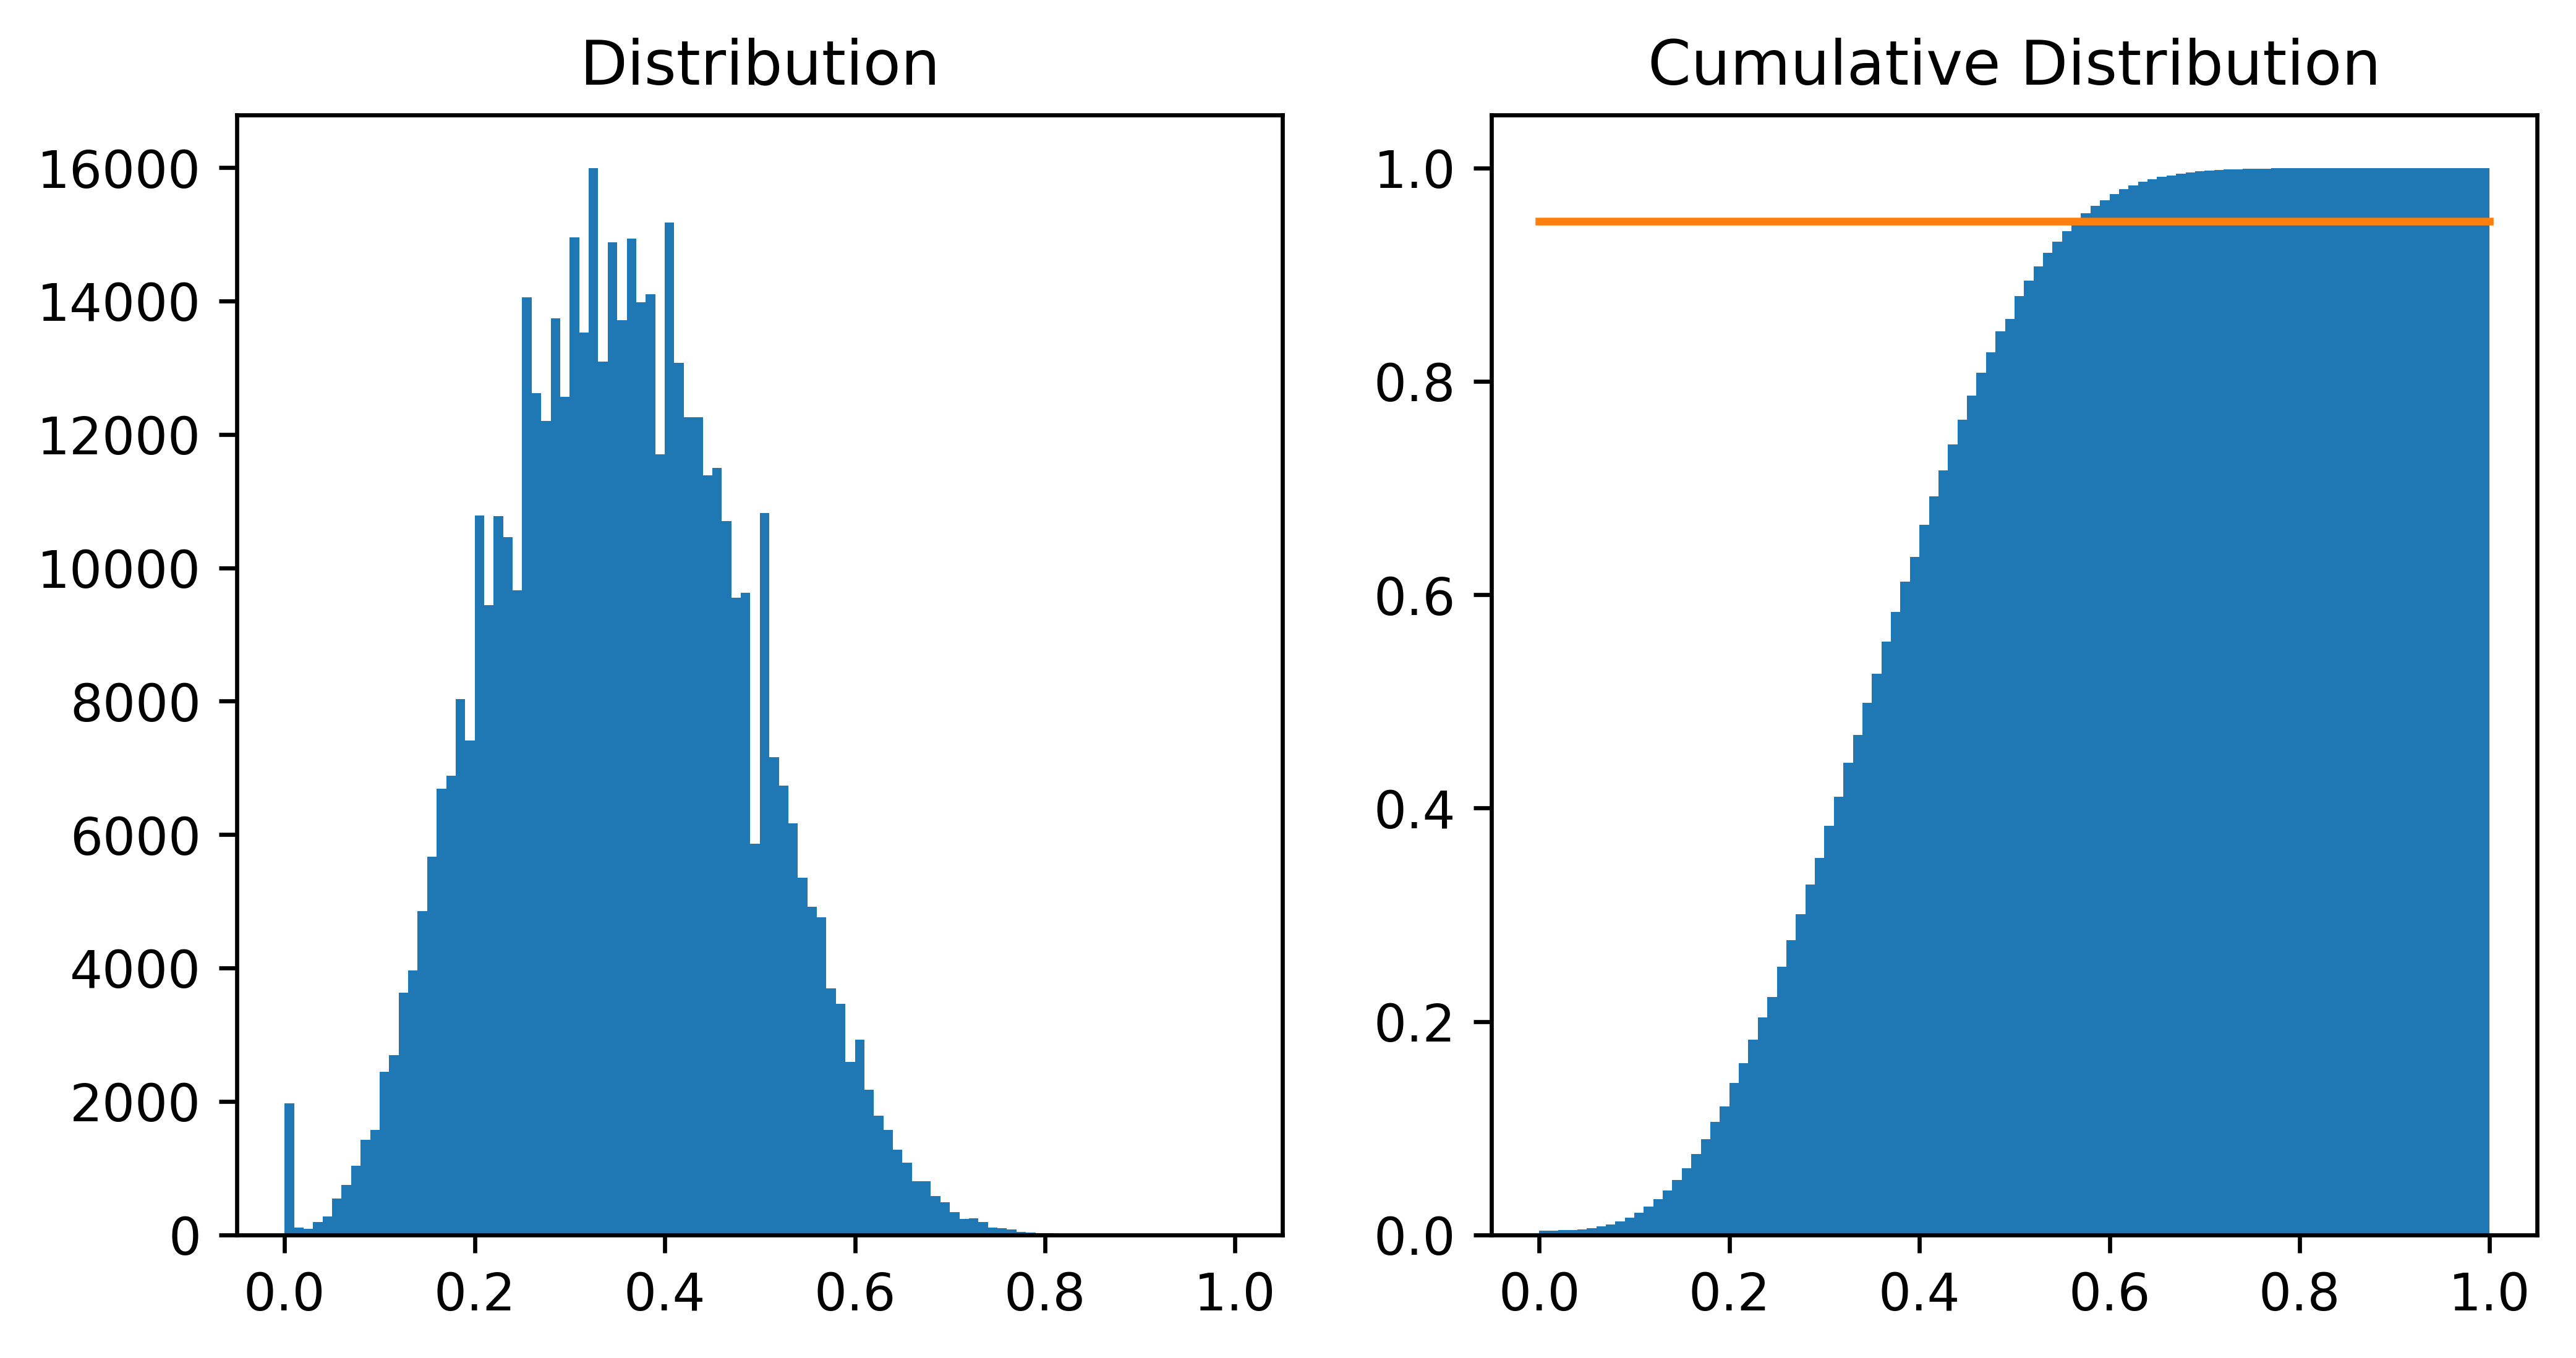

In [106]:
mybins = [x * 0.01 for x in range(101)]

fig = plt.figure(figsize=(8, 4), dpi=300)

plt.subplot(1, 2, 1)
plt.title('Distribution')
plt.hist(scores, bins=mybins)

plt.subplot(1, 2, 2)
plt.title('Cumulative Distribution')
plt.hist(scores, bins=mybins, density=True, cumulative=1)
plt.plot([0, 1], [0.95, 0.95])

In [107]:
for i in range(21):
    
    thresh = i / 20
    num_similar_pairs = len([x for x in scores if x >= thresh])
    prob = num_similar_pairs / len(scores) * 100
    print('{:.3f} {:8d} ({:8.4f})'.format(thresh, num_similar_pairs, round(prob, 4)))

0.000   499500 (100.0000)
0.050   496871 ( 99.4737)
0.100   491543 ( 98.4070)
0.150   473957 ( 94.8863)
0.200   439278 ( 87.9435)
0.250   388148 ( 77.7073)
0.300   322964 ( 64.6575)
0.350   251477 ( 50.3457)
0.400   182073 ( 36.4511)
0.450   117916 ( 23.6068)
0.500    70666 ( 14.1473)
0.550    34421 (  6.8911)
0.600    14994 (  3.0018)
0.650     5251 (  1.0513)
0.700     1550 (  0.3103)
0.750      359 (  0.0719)
0.800       79 (  0.0158)
0.850       15 (  0.0030)
0.900        2 (  0.0004)
0.950        0 (  0.0000)
1.000        0 (  0.0000)


In [108]:
print('average:', sum(scores)/len(scores))

average: 0.35327931654109257


In [110]:
scores.sort()

# find thereshold for top 3% compound pairs (97% percentile)
print('# total compound pairs', len(scores))
print('# 95% of compound pairs', len(scores) * 0.97)
print('# score at 95% percentile', scores[round(len(scores) * 0.97)])

# total compound pairs 499500
# 95% of compound pairs 484515.0
# score at 95% percentile 0.6


In [140]:
# generate 1000 random compounds and get smiles
# to fp
# calc similarity
# plot hist

def get_compounds(num):
    
    cid_max = 138962044
    cids = []
    for x in range(num):
        cids.append(random.randint(1, cid_max + 1))
        
    return cids

def cids_to_smiles(cids):
    
    chunk_size = 100
    
    # extra chunk for uneven division
    if len(cids) % chunk_size == 0:
        num_chunks = len(cids) // chunk_size
    else:
        num_chunks = len(cids) // chunk_size + 1
        
    smiles = []
    for i in range(num_chunks):
        print(f'processing chunk {i}')
        
        idx1 = chunk_size * i
        idx2 = chunk_size * (i+1)
        str_cids = ','.join([str(x) for x in cids[idx1:idx2]])

        url = prolog + '/compound/cid/' + str_cids + '/property/isomericsmiles/txt'
        res = requests.get(url)

        if res.status_code == 200:
            smiles.extend(res.text.split())

        else:
            print(f'chunk {i} failed to get smiles')

        time.sleep(0.2)
        
    return smiles


def get_pubmed_fp(smiles):
    
    fps = []
    for i, smile in enumerate(smiles):
        
        url = prolog + f'/compound/smiles/property/fingerprint2d/txt'
        data = {'smiles' : smile}
        r = requests.post(url, data=data)
        
        if r.status_code == 200:
            fps.append(r.text.strip())
        else:
            print(f'chunk {i} failed to get smiles')
            
    # convert from base64 to bit string
    fps = [PCFP_BitString(fp) for fp in fps]
    
    # convert to rdkit bit vector
    fps = [DataStructs.CreateFromBitString(fp) for fp in fps]
        
    return fps

        
def get_maccs(smiles):
    
    mols = [Chem.MolFromSmiles(smile) for smile in smiles]
    fps = [MACCSkeys.GenMACCSKeys(mol) for mol in mols if mol is not None]
    
    return fps
    

def get_morgan(smiles):
    
    mols = [Chem.MolFromSmiles(smile) for smile in smiles]
    fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in mols]
    
    return fps
    
def tanimoto_sim(fps):
     
    combos = combinations(fps, 2)
    sims = [round(DataStructs.TanimotoSimilarity(*combo), 4) for combo in combos]
    
    return sims

def dice_sim(fps):
    
    combos = combinations(fps, 2)
    sims = [round(DataStructs.DiceSimilarity(*combo), 4) for combo in combos]
    
    return sims

def cosine_sim(fps):
    
    combos = combinations(fps, 2)
    sims = [round(DataStructs.CosineSimilarity(*combo), 4) for combo in combos]
    
    return sims

def plot_sim(sims):
    
    # bin scores from 0-1 with increment of 0.01
    bins = [x * 0.01 for x in range(101)]
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    ax[0].hist(sims, bins=bins)
    ax[1].hist(sims, bins=bins, cumulative=1, density=True)
    
    ax[0].set_title('Distribution')
    ax[1].set_title('Cumulative Distribution')
    
    # 99% threshold
    ax[1].plot([0, 1], [0.99, 0.99])
    
    plt.tight_layout()
    
def ex_3a(fingerprint, similarity):
    
    assert fingerprint in ['pubchem', 'maccs', 'morgan'], 'invalid fingerprint'
    assert similarity in ['tanimoto', 'dice', 'cosine'], 'invalid similarity'
    
    # get compounds
    cids = get_compounds(1000)
    
    # to smiles
    smiles = cids_to_smiles(cids)
    
    # to fp
    if fingerprint == 'pubchem':
        fps = get_pubmed_fp(smiles)
    elif fingerprint == 'maccs':
        fps = get_maccs(smiles)
    elif fingerprint == 'morgan':
        fps = get_morgan(smiles)
    
    # calc similarity
    if similarity == 'tanimoto':
        sims  = tanimoto_sim(fps)
    elif similarity == 'dice':
        sims = dice_sim(fps)
    elif similarity == 'cosine':
        sims = cosine_sim(fps)
    
    # 99% threshold
    thresh = np.percentile(sims, 99)
    
    # plot
    plot_sim(sims)
    plt.suptitle(f'{fingerprint} - {similarity}, thresh = {thresh:.4f}', size=13, y=1.03)
    
    

In [137]:
fps = ['pubchem', 'maccs', 'morgan']
sims = ['tanimoto', 'dice', 'cosine']

combos = list(product(fps, sims))

processing chunk 0
processing chunk 1
processing chunk 2
processing chunk 3
processing chunk 4
processing chunk 5
processing chunk 6
processing chunk 7
processing chunk 8
processing chunk 9


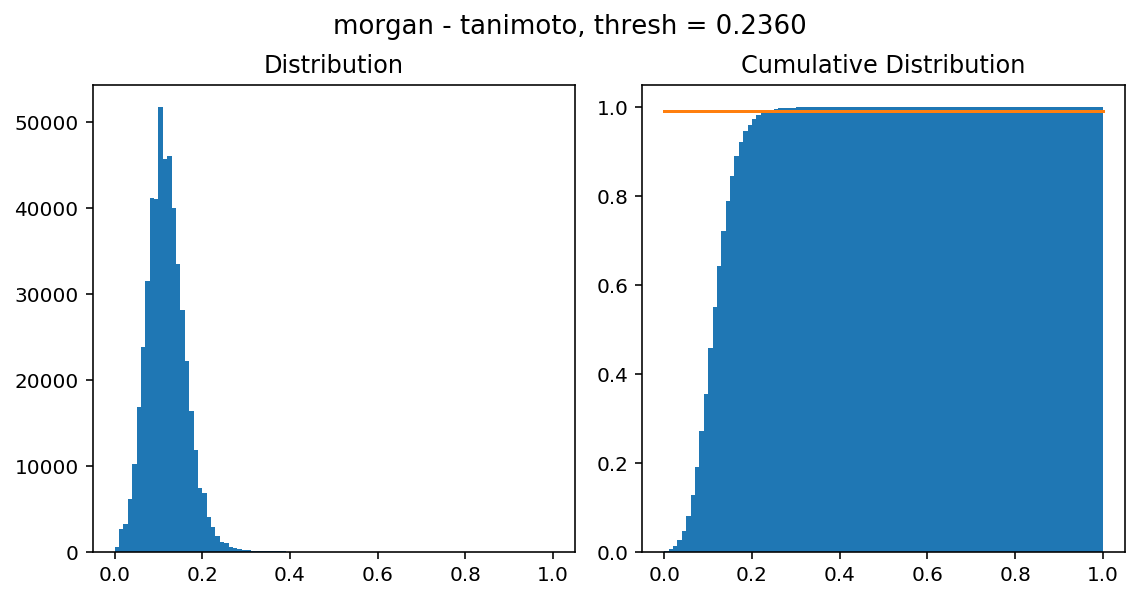

In [141]:
ex_3a('morgan', 'tanimoto')

processing chunk 0
processing chunk 1
processing chunk 2
processing chunk 3
processing chunk 4
processing chunk 5
processing chunk 6
processing chunk 7
processing chunk 8
processing chunk 9


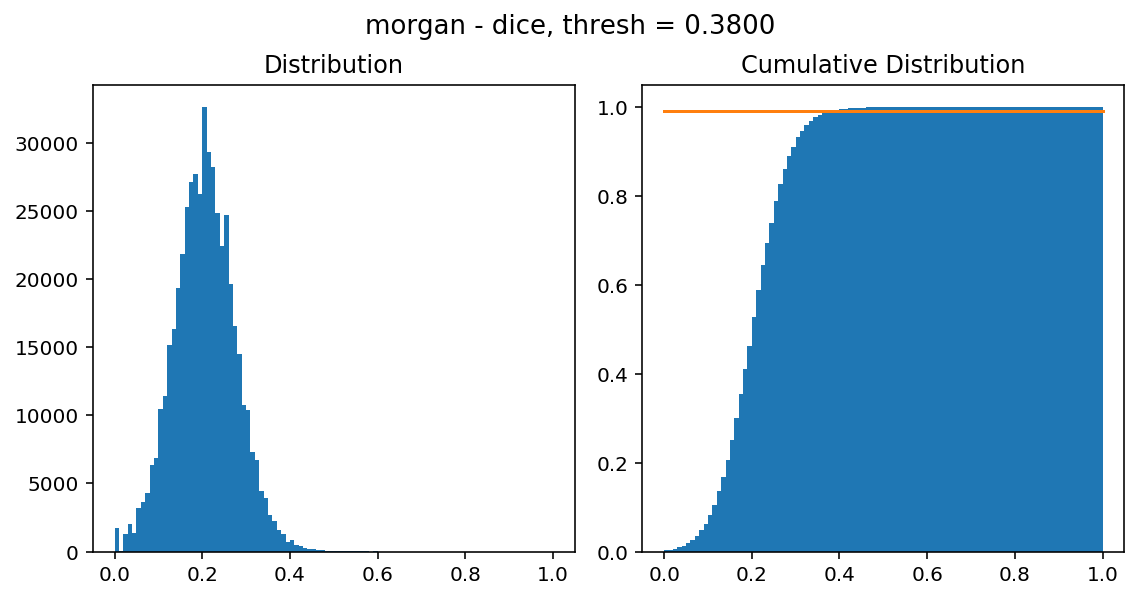

In [144]:
ex_3a('morgan', 'dice')

processing chunk 0
processing chunk 1
processing chunk 2
processing chunk 3
processing chunk 4
processing chunk 5
processing chunk 6
processing chunk 7
processing chunk 8
processing chunk 9


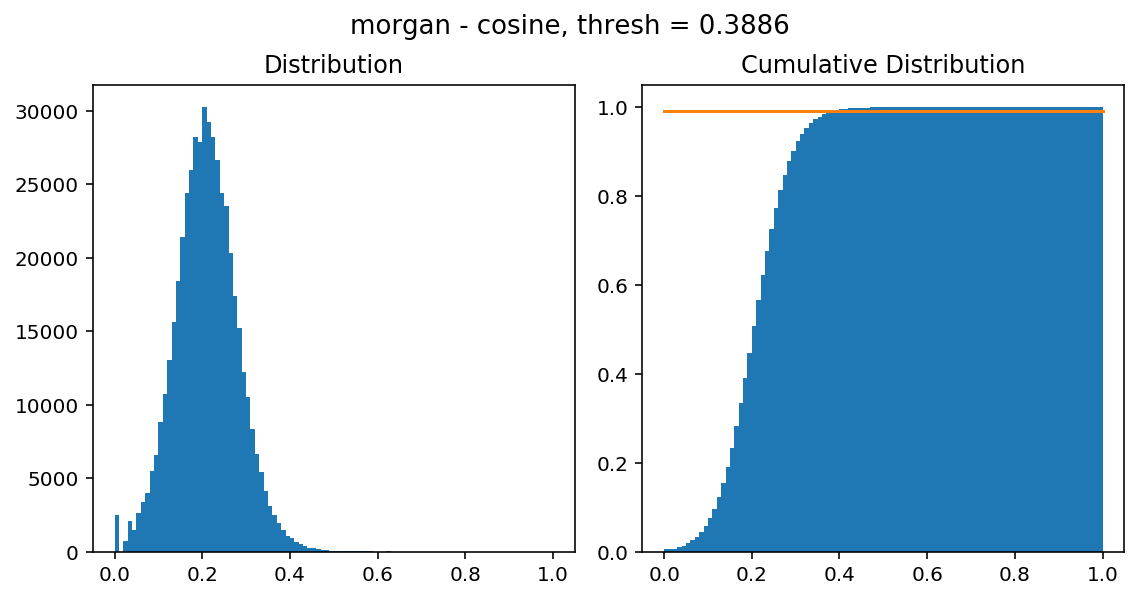

In [145]:
ex_3a('morgan', 'cosine')

processing chunk 0
processing chunk 1
processing chunk 2
processing chunk 3
processing chunk 4
processing chunk 5
processing chunk 6
processing chunk 7
processing chunk 8
processing chunk 9


RDKit ERROR: [02:37:12] Explicit valence for atom # 1 H, 2, is greater than permitted


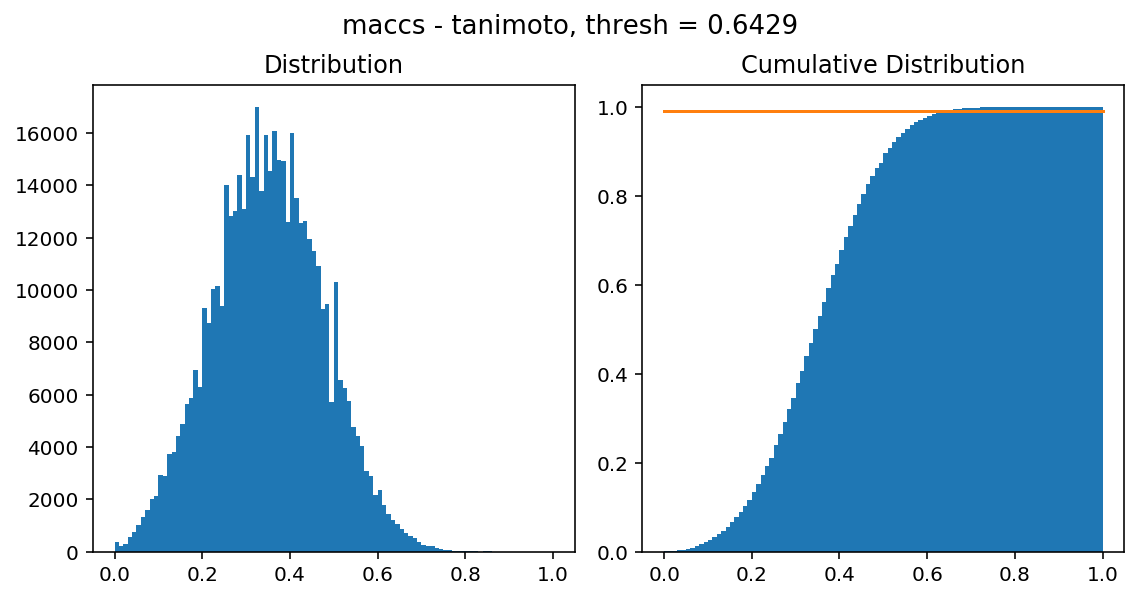

In [146]:
ex_3a('maccs', 'tanimoto')

processing chunk 0
processing chunk 1
processing chunk 2
processing chunk 3
processing chunk 4
processing chunk 5
processing chunk 6
processing chunk 7
processing chunk 8
processing chunk 9


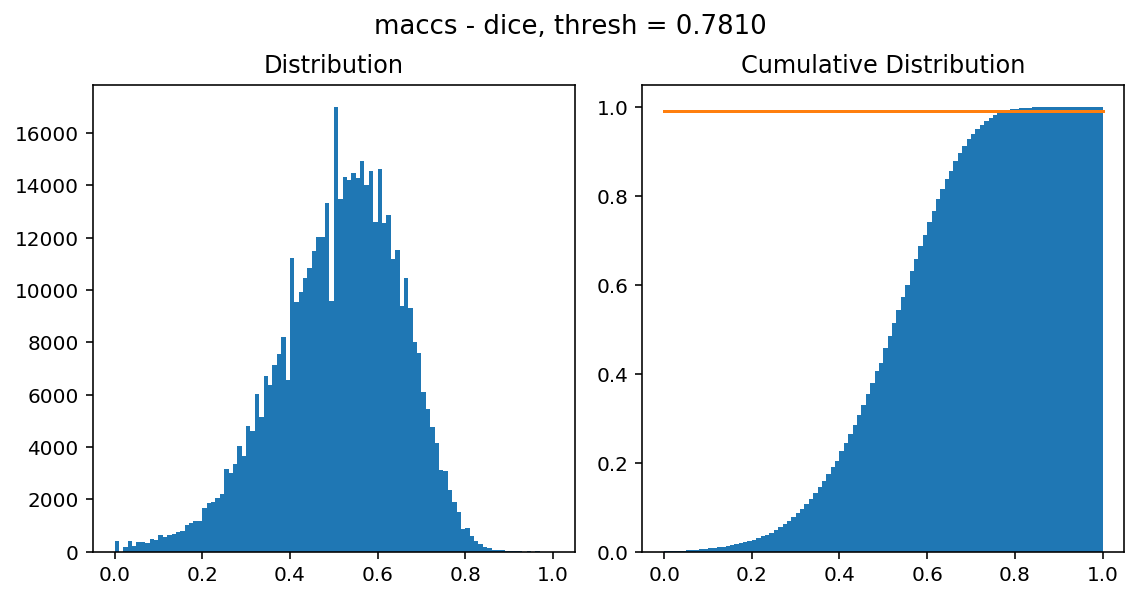

In [147]:
ex_3a('maccs', 'dice')

processing chunk 0
processing chunk 1
processing chunk 2
processing chunk 3
processing chunk 4
processing chunk 5
processing chunk 6
processing chunk 7
processing chunk 8
processing chunk 9


RDKit WARNING: [02:37:43] WARNING: not removing hydrogen atom without neighbors


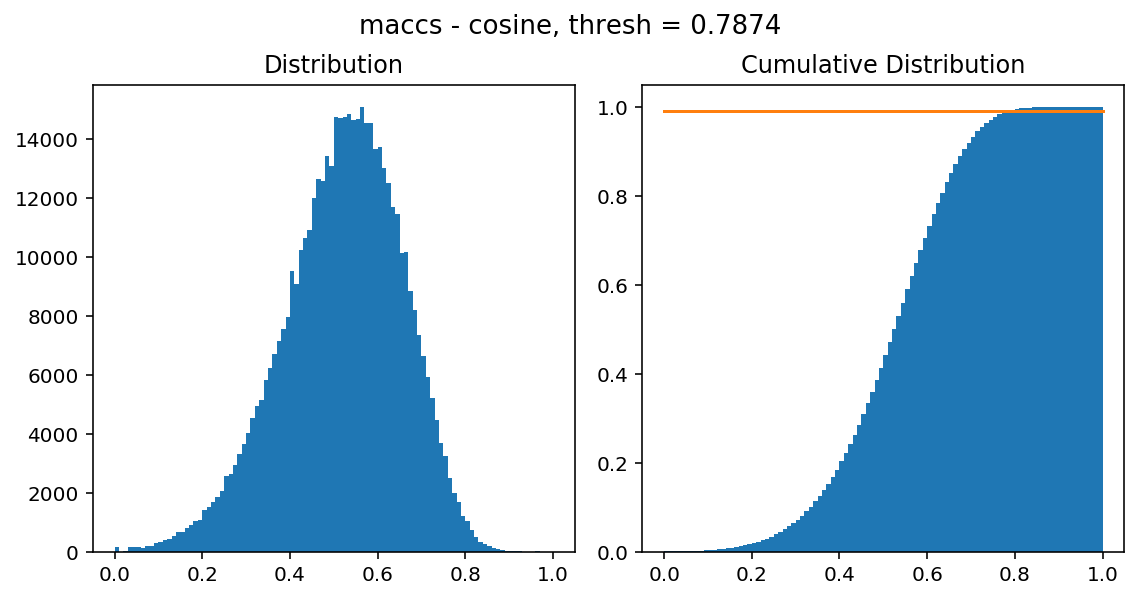

In [148]:
ex_3a('maccs', 'cosine')